# Difussion equation

Solving the poisson equation $u_t-\Delta u = f$ using a physics informed neural network in multi dim.

![flow_learn_diagram](https://user-images.githubusercontent.com/35903705/90431457-b2ebd800-e08e-11ea-9bdd-dde98b2673f7.jpg)

### Manufactured solution


We use $u = t\sin (x+y)$ for $x \in X_1\times X_2$, $t\in[t_1,t_2]$ to manufacture the rhs of the difussion equation above.

### Importing packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

import DataProcess
# import FluidModels
# import Losses

### Manufacturing data for trainig

In [792]:
np.random.seed(123)
pde_data_size = 4000
bc_data_size = 1000

#domain range
X_1_domain = [-2, 2]
X_2_domain = [0, 1]
#time range
T_initial = 0
T_final = 1
T_domain = [T_initial, T_final]

#space data
space_dim = 2
X_1_tr_pde = np.random.uniform(X_1_domain[0], X_1_domain[1], pde_data_size).reshape(pde_data_size,1)
X_2_tr_pde = np.random.uniform(X_2_domain[0], X_2_domain[1], pde_data_size).reshape(pde_data_size,1)
# X_tr_pde = np.random.uniform(-1,1,pde_data_size*space_dim).reshape(pde_data_size,space_dim)

#temporal data
X_tr_time = np.random.uniform(T_initial, T_final, pde_data_size).reshape(pde_data_size,1)

X_tr_pde = np.concatenate([X_1_tr_pde, X_2_tr_pde, X_tr_time],axis=1)
X_1_tr_pde.shape

(4000, 1)

In [793]:
X_tr_pde.shape

(4000, 3)

### Looking at the scatter plot of data

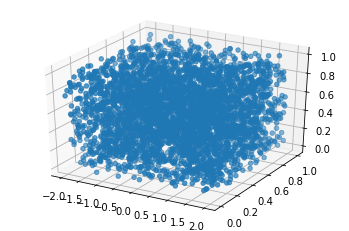

In [794]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tr_pde[:,0],X_tr_pde[:,1],X_tr_pde[:,2])


### Defining the labels(true values) for the training data

In [795]:
Y_tr_pde = np.zeros((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [796]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(4000, 2)

## BC data 

In [797]:
# bc_data_size = 100

X_bc_left = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([X_1_domain[0]*np.ones((bc_data_size,1)),
                            X_bc_left], axis=1)
X_bc_left = np.concatenate([X_bc_left,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_bottom = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, X_2_domain[0]*np.ones((bc_data_size,1))],
                             axis=1)
X_bc_bottom = np.concatenate([X_bc_bottom,
                              np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_right = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([X_1_domain[1]*np.ones((bc_data_size,1)),
                            X_bc_right], axis=1)
X_bc_right = np.concatenate([X_bc_right,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_top = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, X_2_domain[1]*np.ones((bc_data_size,1))],
                          axis=1)
X_bc_top = np.concatenate([X_bc_top,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_bottom, X_bc_right, X_bc_top],axis=0)

#Add iniital condition below: add them to be X_ic and finallly concatenate bc and ic to get X_bc_ic
X_ic = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_ic = np.concatenate([X_ic, np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)],
                          axis=1)
X_ic = np.concatenate([X_ic,
                            T_initial*np.ones((bc_data_size,1))], 
                            axis=1)

In [798]:
X_bc_ic = np.concatenate([X_bc, X_ic],axis=0)

In [799]:
X_bc_ic

array([[-2.        ,  0.63441982,  0.96318496],
       [-2.        ,  0.81757785,  0.03587243],
       [-2.        ,  0.43410143,  0.98620288],
       ...,
       [-1.7023154 ,  0.12822023,  0.        ],
       [ 1.17950304,  0.40016341,  0.        ],
       [ 0.28374797,  0.38824039,  0.        ]])

In [800]:
Y_bc_ic = np.sin(X_bc_ic[:,0:1] + X_bc_ic[:,1:2]) * X_bc_ic[:,2:3]
# Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

### Saving the data to a csv file

In [801]:
combined_data = np.concatenate([X_bc_ic,Y_bc_ic],axis=1)

In [802]:
DataProcess.save_to_csv(combined_data, "data_manufactured/t_sin_x_plus_y")

In [803]:
X_data, Y_data = DataProcess.imp_from_csv("data_manufactured/t_sin_x_plus_y.csv",
                                             True,1)

In [804]:
data_processor = DataProcess.Data_preprocess(2, dom_bounds=[X_1_domain,X_2_domain,T_domain], time_dep=True)

In [805]:
X_tr, Y_tr = data_processor.get_training_data(X_data,Y_data, X_col_points=pde_data_size)

In [806]:
# X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
# Y_tr = np.concatenate((Y_tr_pde, Y_bc), axis=0)

## Training the model

In [807]:

def rhs_function (args, time_dep=True):
        if time_dep:
            space_inputs = args[:-1]
            time_inputs = args[-1]
        else:
            space_inputs = args
        
        return tf.sin(space_inputs[0]+space_inputs[1]) + 2*time_inputs*tf.sin(space_inputs[0]+space_inputs[1])

In [808]:
"""
Module containing various loss functions for FluidLearn PDE solver.
"""

import numpy as np
import tensorflow as tf

__author__ = "Manu Jayadharan"
__copyright__ = "Copyright 2020, FluidLearn"
__credits__ = ["Manu Jayadharan"]
__license__ = ""
__version__ = "0.1.0"
__maintainer__ = "Manu Jayadharan"
__email__ = "manu.jayadharan@pitt.edu"
__status__ = "Development"

def u_loss(y_true, y_pred):
    """
    Loss function to take care of boundary and initial data.
    (tensor, tensor) -> tensor
    
    arguments:
    ----------
    y_true (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde). extra 1 dim in 0+1 is to check whether the given point is 
    actually a data (bc,ic) point or a pde collocation point.
    
    y_pred (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde).
    
    output:
    -------
    tensor: of size m x o, where m and o is discussed in arguments. Essentially, loss
    is calucated only for points which have 1 on the last column of y_true. For pde
    collocation points, loss is returned as 0.
    """
    
    y_true_act = y_true[:,:-1]
    #using the last column of y_true_act to check whether the point is at the boundary
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, u_sq_error, 0.)

def pde_loss(y_true, y_pred):
    """
    Loss function to take care of pde constrain. 
    (tensor, tensor) -> tensor
    
    arguments:
    ----------
    y_true (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde). extra 1 dim in 0+1 is to check whether the given point is 
    actually a data (bc,ic) point or a pde collocation point.
    
    y_pred (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde).
    
    output:
    -------
    tensor: of size m x o, where m and o is discussed in arguments. Essentially, loss
    is calucated only for pde collocation points, for input data points (bc,ic etc), the loss 
    is returnd a 0.
    """
    y_true_act = y_true[:,:-1]
    #using the last column of y_true_act to check whether the point is at the boundary
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    pde_sq_error = (1/2)*tf.square(y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

In [809]:
def p_loss_mixed(y_true, y_pred):
    """
    Loss function to take care of boundary and initial data,
    when the pde is in it's mixed form.
    (tensor, tensor) -> tensor
    
    arguments:
    ----------
    y_true (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde). extra 1 dim in 0+1 is to check whether the given point is 
    actually a data (bc,ic) point or a pde collocation point.
    
    y_pred (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde).
    
    space_dim (int) : Dimension of the spatial space Omega. 
    
    output:
    -------
    tensor: of size m x o, where m and o is discussed in arguments. Essentially, loss
    is calucated only for points which have 1 on the last column of y_true. For pde
    collocation points, loss is returned as 0.
    """
    y_true_act = y_true[:,0:1]
    #using the last column of y_true_act to check whether the point is at the boundary
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    p_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, p_sq_error, 0.)

def p_pde_loss_mixed(y_true, y_pred):
    """
    Loss function to take care of pressure(scalar) pde constrain. 
    (tensor, tensor) -> tensor
    
    arguments:
    ----------
    y_true (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde). extra 1 dim in 0+1 is to check whether the given point is 
    actually a data (bc,ic) point or a pde collocation point.
    
    y_pred (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde).
    
    output:
    -------
    tensor: of size m x o, where m and o is discussed in arguments. Essentially, loss
    is calucated only for pde collocation points, for input data points (bc,ic etc), the loss 
    is returnd a 0.
    """
    y_true_act = y_true[:,:-1]
    #using the last column of y_true_act to check whether the point is at the boundary
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    pde_sq_error = (1/2)*tf.square(y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

def u_pde_loss_mixed(y_true, y_pred):
    """
    Loss function to take care of velocity pde constrain (A vector is coming in as y_pred). 
    (tensor, tensor) -> tensor
    
    arguments:
    ----------
    y_true (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde). extra 1 dim in 0+1 is to check whether the given point is 
    actually a data (bc,ic) point or a pde collocation point.
    
    y_pred (tensor) : tensor of size m x o+1, where m is the data size and o is the 
    dimension of the output of the major neural net (same as dimension of range of 
    soluton to the pde).
    
    output:
    -------
    tensor: of size m x o, where m and o is discussed in arguments. Essentially, loss
    is calucated only for pde collocation points, for input data points (bc,ic etc), the loss 
    is returnd a 0.
    """
    y_true_act = y_true[:,:-1]
    #using the last column of y_true_act to check whether the point is at the boundary
    at_boundary = tf.cast(y_true[:,-1:,],bool)
#     y_pred_tensor = tf.convert_to_tensor(y_pred)
    pde_sq_error = (1/2)*tf.square(y_pred)
#     return tf.where(at_boundary,0.,tf.reduce_mean(pde_sq_error, axis=-1))
    return tf.where(at_boundary,0., pde_sq_error)

##  Fluid model module copied here

In [810]:
"""
Module containng custom Keras models and layers required for FlowNet architecture.
"""

try:     
    import numpy as np
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import backend as K
except Exception as e:
        raise Exception("Error occured while importing dependency packages. More details:\n",e)
        
__author__ = "Manu Jayadharan"
__copyright__ = "Copyright 2020, FlowNet"
__credits__ = ["Manu Jayadharan"]
__license__ = ""
__version__ = "0.1.0"
__maintainer__ = "Manu Jayadharan"
__email__ = "manu.jayadharan@pitt.edu"
__status__ = "Development"     

class ForwardModel(tf.keras.Model):
    """
    Model to construct FNN (Forward Neural Network) using custom Keras layers. Subclass of tf.keras.Model
    """
      
    def __init__(self, space_dim=1, time_dep=False, output_dim=1,
                 n_hid_lay=3, n_hid_nrn=20, act_func = "tanh", rhs_func = None):
        """
        space_dim (int) -> Dimension of the space Omega where the PDE is defined.
        time_dep (bool) -> True if the problem is time dependent.
        output_dim (int) -> Dimension of the range of the solution to PDE.
        
        n_hid_layer (int) -> Number of hidden layers in the neural network.
        n_hid_nrn (int) -> Number of neurons in each hidden layer of the NN.
        
        act_func (string) -> Activation functions for each of the hidden layers. Has to
                            be one of the members of keras.activations: could be one of
                            {"tanh", "sigmoid", "elu", "relu", "exponential"}
        """
        
        super(ForwardModel, self).__init__()
        
        #Defining class atributes
        self.space_dim = space_dim
        self.time_dep = time_dep
        self.output_dim = output_dim
        self.n_hid_lay = n_hid_lay
        self.n_hid_nrn = n_hid_nrn
        
        #Block of hidden layers
        self.hidden_block = [keras.layers.Dense( self.n_hid_nrn, activation=act_func,
                                           name="dense_"+str(i+1) ) for i in range(n_hid_lay)]
        #Final output layer
        self.final_layer = keras.layers.Dense(self.output_dim,
                                         name="final_layer")        
        
        #Defining the rhs of PDE: P(u,delu) = f(x,t)
        if rhs_func != None:
            self.rhs_function = rhs_func
        else:
            self.rhs_function = lambda x: 0
        
    def findGrad(self,func,input_space):
        """
        Find gradient with respect to the domain Omega of the PDE. 
        (tensor, tensor) -> Keras.Lambda layer
        
        arguments:
        ----------
        func (tf tensor): function represented by tf tensor structure (Usually of size:
              data_size x dim_output_previous_layer). The func is usually the final output (solution u)
              coming out of a hidden layer
        
        input_space: argument with respect to which we need the partial derrivatives of func. Usually a list of 
              input arguments representing the space dimension.
        
        Output: Keras.Lambda layer. Note that output of such a lambda layer will be a list of tensors with
                each element giving partial derrivative wrt to each element in argm.
        
        See tf.Keras.Lambda and tf.gradients for more details.
        
        """
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func, input_space])
        except Exception as e:
            raise Exception("Error occured in finding the time derrivative  lambda layer of type {} as follows: \n{}".format(type(e)),e)
          
        
    def findTimeDer(self,func,input_time):
        """
        (tensor, tensor) -> Keras.Lambda layer
        
        arguments:
        ----------
        func (tf tensor): function represented by tf tensor structure (Usually of size:
              data_size x dim_output_previous_layer). The func is usually the final output (solution u)
              coming out of a hidden layer
        
        input_time: TensorFlow tensor. This should be the element of the input list which corresponds to the time
              dimension. Used only if the problem is time_dependent.
        
        Output: Keras.Lambda layer. Note that output of such a lambda layer will be a tensor of size m x 1 
                representing the time derrivative of output func.
        
        
        See tf.Keras.Lambda and tf.gradients for more details.
        
        """
        assert (self.time_dep), "Tried taking time derrivative even though the problem is not time dependent."
        try:
            return keras.layers.Lambda(lambda z: tf.gradients(z[0],z[1],
                                                               unconnected_gradients='zero') [0]) ([func, input_time])
        except Exception as e:
            raise Exception("Error occured in find gradient lambda layer of type {} as follows: \n{} ".format(type(e)),e)
            
            
    def findLaplace(self,first_der,input_space):
        """
        (tensor, tensor) -> Keras.Lambda layer
        
        Returns lambda layer to find the laplacian of the solution to pde. 
        
        arguments:
        ----------
        first_der (tf tensor): function represented by tf tensor structure (Usually of size:
              data_size x dim_output_previous_layer). The func is 
        
        input_space: argument with respect to which we need the partial derrivatives of func. Usually a list of 
                     input arguments representing the space dimension.
        
        Output: Keras.Lambda layer. This lambda layer outputs the laplacian of solution function u.  
        
        See tf.Keras.Lambda and tf.gradients for more details.
        
        """
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([first_der,input_space])
            return sum(del_sq_layer)
                
        except Exception as e:
            raise Exception("Error occured in find laplacian lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    #final layer representing the lhs P(x,t) of PDE P(x,t)=0
    def findPdeLayer(self, laplacian, input_arg, time_der=0):
        """
        (tensor, tensor, tensor) -> Keras.Lambda layer
        
        Returns lambda layer to find the actual pde P(u,delu,x,t) such that P(u,delu,x,t)=0. 
        
        arguments:
        ----------
        laplacian (tf tensor): laplacian with respect to space dim .
        
        input_arg: list of inputs corresponding to both space and time dimension. Last elemetn of 
                   the list corresponds to the temporal dimension.
        
        Output: Keras.Lambda layer. This lambda layer outputs the PDE P(u,delu, x,t).  
        
        See tf.Keras.Lambda and tf.gradients for more details.
        
        """
        try:
#             return keras.layers.Lambda(lambda z: z[0] - z[1] - tf.sin(z[2][0]+z[2][1]) - 
#                                        2*z[2][2]*tf.sin(z[2][0]+z[2][1])) ([time_der, laplacian, input_arg])
            return keras.layers.Lambda(lambda z: z[0] - z[1] - self.rhs_function(input_arg)) ([time_der, laplacian, input_arg])
        except Exception as e:
            raise Exception("Error occured in finding pde  lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    def get_config(self):
        #getting basic config using the parent model class
        base_config = super().get_config()
        return {**base_config, "space_dim": self.space_dim, 
                "time_dep": self.time_dep, "output_dim": self.output_dim,
                 "n_hid_lay": self.n_hid_lay, "n_hid_nrn": self.n_hid_nrn,
                "act_func": self.act_func }
    
    def from_config(self, config, custom_objects):
        super().from_config(config)
    
    def call(self, inputs, training=False):
        """
        Call function which wll be used while training, prediciton and evaluation of the ForwardModel. 
        
        arguments:
        ----------
        inputs (list of tensors) -> last element of the list corresponds to temporal diimension if 
                                    self.time_dep = True. If possible, always feed the data from the 
                                    data processing method in flowDataProcess module.
        training (bool) -> True if calling the function for training. False for prediction and evaluation. 
                           Value of triainng will be automatically taken care of by Keras. 
        
        Note that inputs should always be given as a list with the last element of the list representing the 
        dimension corresponding to time.
        """
        if self.time_dep:
            try:
                assert(len(inputs) > 1)
                input_space = inputs[:-1]
                input_time = inputs[-1]
            except Exception as e:
                raise Exception("Error occured while separating spacial and temporal data from inputs,\
                make sure that spacio-temporal data is being used to for training and \
                x=[space_dim1,..,space_dimn,time_dim]. More details on error below:\n", type(e), e)
        else:
            input_space = inputs
        
        #concatening all the input data (space and time dimensions) making it 
        #read to be passed to the hidden layers
        hidden_output = keras.layers.concatenate(inputs) 
        
        #hidden layers
        for layer_id in range(self.n_hid_lay):
            hidden_output = self.hidden_block[layer_id] (hidden_output)

        
        #output layer, this is typically the solution function
        output_layer = self.final_layer(hidden_output)
        
        if training:
            #pde specific layers
            grad_layer = self.findGrad(output_layer, input_space)
            laplace_layer = self.findLaplace(grad_layer, input_space)
            if self.time_dep: 
                time_der_layer = self.findTimeDer(output_layer, input_time)
            else:
                time_der_layer=0
            pde_layer = self.findPdeLayer(laplace_layer, inputs, time_der_layer)

            return output_layer, pde_layer
        
        elif not training: #only outputting the function value if not tranining.
                return output_layer


        

In [811]:
class MixedDif(ForwardModel):
    """
    Doc string goes here
    """
    
    def __init__(self, space_dim=1, perm_tensor=None, output_dim=1,
                 n_hid_lay=3, n_hid_nrn=20, act_func = "tanh", rhs_func = None,
                n_xtr_hid_lay=1):
        """
        talk about super initialization
        """
        
        super().__init__(space_dim=space_dim, time_dep=True, output_dim=output_dim,
                 n_hid_lay=n_hid_lay, n_hid_nrn=n_hid_nrn, act_func = act_func, rhs_func = rhs_func)
        
        self._perm_tensor = perm_tensor if perm_tensor else tf.eye(space_dim)
        self.n_xtr_hid_lay = n_xtr_hid_lay
        
        self.__pressure_dim = 1
        # Defining final output layers for pressure and velocity
        #pressure
        self.__pres_final_layer = keras.layers.Dense(self.__pressure_dim,
                                         name="pressure_out_layer")
        self.__vel_final_layer = keras.layers.Dense(space_dim, name = "velocity_out_layer")
        
        #Block of extra hidden layers for pressure
        self.xtra_hidden_block_pres = [keras.layers.Dense( self.n_hid_nrn, activation=act_func,
                                           name="dense_xtra_pr_"+str(i+1) ) for i in range(n_xtr_hid_lay)]
        
        #Block of extra hidden layers for velocity
        self.xtra_hidden_block_vel = [keras.layers.Dense( self.n_hid_nrn, activation=act_func,
                                           name="dense_xtra_vel_"+str(i+1) ) for i in range(n_xtr_hid_lay)]
        
    def findDivLayer(self,vel_vector,input_space):
        """
        (tensor, tensor) -> Keras.Lambda layer
        
        Returns lambda layer to find the divergence of the velocity vector. 
        
        arguments:
        ----------
        vel_vector (tf tensor): predicted velocity function represented by tf tensor structure (Usually of size:
              data_size x space_dim). 
        
        input_space: argument with respect to which we need the partial derrivatives of func. Usually a list of 
                     input arguments representing the space dimension.
        
        Output: Keras.Lambda layer. This lambda layer outputs the laplacian of solution function u.  
        
        See tf.Keras.Lambda and tf.gradients for more details.
        
        """
        try:
            # list containng diagonal entries of the gradient 
            #on velocity vector. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            grad_diag= keras.layers.Lambda( lambda z: [ tf.gradients(z[0][:,i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([vel_vector,input_space])
            return sum(grad_diag)
                
        except Exception as e:
            raise Exception("Error occured in finding divergence of velocity lambda layer of type {} as follows: \n{}".format(type(e)),e)

    #layer representing the scalar equation in the pde, PDE P_scalar(x,t)=0.
    #This is typically something of the form p_t - div(u) -f =0
    def findPdeLayer_1(self, div_vel, input_arg, time_der=0):
        """
        (tensor, tensor, tensor) -> Keras.Lambda layer
        
        Returns lambda layer to find the actual pde P(u,delu,x,t) such that P(u,delu,x,t)=0. 
        
        arguments:
        ----------
        div_vel(tf tensor): divergence of velocity vector with respect to space dim .
        
        input_arg: list of inputs corresponding to both space and time dimension. Last elemetn of 
                   the list corresponds to the temporal dimension.
        
        time_der (tf tensor): derrivative of the pressure function with respect to time.
        
        Output: Keras.Lambda layer. This lambda layer outputs the PDE P(u,delu, x,t).  
        
        See tf.Keras.Lambda and tf.gradients for more details.
        
        """
        try:
#             return keras.layers.Lambda(lambda z: z[0] - z[1] - tf.sin(z[2][0]+z[2][1]) - 
#                                        2*z[2][2]*tf.sin(z[2][0]+z[2][1])) ([time_der, laplacian, input_arg])
            return keras.layers.Lambda(lambda z: z[0] + z[1] - self.rhs_function(input_arg)) ([time_der, div_vel, input_arg])
        except Exception as e:
            raise Exception("Error occured in finding pressure pde  lambda layer of type {} as follows: \n{}".format(type(e)),e)
     
    
    #layer representing the vector equation in the pde, PDE PDE_vector(x,t)=0.
    #This is typically something of the form grad(p) + u = 0 
    def findPdeLayer_2(self, grad_p, vel_vect):
        """
        (tensor, tensor) -> Keras.Lambda layer
        
        Returns list of lambda layer to find the vector PDE= 0 in the mixed form.
        
        arguments:
        ----------
        grad_p(list of tf tensors): gradient of p with respect so spacedim. each element of the list
                    corresponds to the partial with respect to different variable in spacedim..
        
        vel_vect(tensor): velocity vector coming from teh final xtra hidden layer. This has shape,
                            num_instances*vel_dim. note that vel_dim = space_dim.
        
        Output: list of  Keras.Lambda layer. This lambda layer outputs a list representing the vector
                equation grad(p) + u =0.
        
        """
        try:
#             return keras.layers.Lambda(lambda z: tf.convert_to_tensor([z[0][i] + z[1][:,i:i+1] for i in range(len(grad_p))])) ([grad_p, vel_vect])
            return keras.layers.Lambda(lambda z: [z[i][0] + z[1][:,i:i+1] for i in range(len(grad_p))]) ([grad_p, vel_vect])
        except Exception as e:
            raise Exception("Error occured in finding vector pde  lambda layer of type {} as follows: \n{}".format(type(e)),e)

    def call(self, inputs, training=False):
        """
        Call function which wll be used while training, prediciton and evaluation of the ForwardModel. 
        
        arguments:
        ----------
        inputs (list of tensors) -> last element of the list corresponds to temporal diimension if 
                                    self.time_dep = True. If possible, always feed the data from the 
                                    data processing method in flowDataProcess module.
        training (bool) -> True if calling the function for training. False for prediction and evaluation. 
                           Value of triainng will be automatically taken care of by Keras. 
        
        Note that inputs should always be given as a list with the last element of the list representing the 
        dimension corresponding to time.
        """
        if self.time_dep:
            try:
                assert(len(inputs) > 1)
                input_space = inputs[:-1]
                input_time = inputs[-1]
            except Exception as e:
                raise Exception("Error occured while separating spacial and temporal data from inputs,\
                make sure that spacio-temporal data is being used to for training and \
                x=[space_dim1,..,space_dimn,time_dim]. More details on error below:\n", type(e), e)
        else:
            input_space = inputs
        
        #concatening all the input data (space and time dimensions) making it 
        #read to be passed to the hidden layers
        hidden_output = keras.layers.concatenate(inputs) 
        
        #hidden layers
        for layer_id in range(self.n_hid_lay):
            hidden_output = self.hidden_block[layer_id] (hidden_output)

        
#         #output layer, this is typically the solution function
#         output_layer = self.final_layer(hidden_output)
        
        #pressure output layer
#         for layer_id in range(self.n_xtr_hid_lay):
#             hidden_output = self.xtra_hidden_block[layer_id] (hidden_output)
#             pres_output_layer = self.xtra_hidden_block_pres[layer_id] (hidden_output) if layer_id == 0 else self.xtra_hidden_block_pres[layer_id] (pres_output_layer)
#         pres_output_layer = self.__pres_final_layer(pres_output_layer)
        pres_output_layer = self.__pres_final_layer(hidden_output)
        
        #velocity output layer
        for layer_id in range(self.n_xtr_hid_lay):
            hidden_output = self.xtra_hidden_block_vel[layer_id] (hidden_output)
        vel_output_layer = self.__vel_final_layer(hidden_output)
        
        if training:
            #pde specific layers
            
            #finding gradient of pressure with respect to space dim
            grad_layer = self.findGrad(pres_output_layer, input_space)
            #finding divergence of the velocity layer with respect to space dim
            div_layer = self.findDivLayer(vel_output_layer, input_space)
        
            
            if self.time_dep: 
                time_der_layer = self.findTimeDer(pres_output_layer, input_time)
            else:
                time_der_layer=0
            #PDE_1 = 0 the scalar equation of the form p_t - div(u) -f = 0
            pde_layer_1 = self.findPdeLayer(div_layer, inputs, time_der_layer)
            pde_layer_2 = self.findPdeLayer_2(grad_layer, vel_output_layer)

#             return pres_output_layer, pde_layer_1, pde_layer_2
            return pres_output_layer, pde_layer_1, pde_layer_2[0], pde_layer_2[1]
        
        elif not training: #only outputting the function value if not tranining.
                return pres_output_layer, vel_output_layer
#                 return pres_output_layer


In [812]:
# import FluidModels

In [813]:
# pinn_model = FluidModels.ForwardModel(space_dim=2, time_dep=True, rhs_func = rhs_function)
# pinn_model = FluidModels.ForwardModel(space_dim=2, time_dep=True, rhs_func = None)
pinn_model = MixedDif(space_dim=2, perm_tensor=None, output_dim=1,
                 n_hid_lay=3, n_hid_nrn=20, act_func = "tanh", rhs_func = rhs_function,
                n_xtr_hid_lay=1)

In [814]:

def rhs_function (args, time_dep=True):
        if time_dep:
            space_inputs = args[:-1]
            time_inputs = args[-1]
        else:
            space_inputs = args
        
        return tf.sin(space_inputs[0]+space_inputs[1]) + 2*time_inputs*tf.sin(space_inputs[0]+space_inputs[1])

In [815]:
def dummy_loss(y_true, y_pred):
    return y_pred[:,0:1]
# pinn_model.compile(loss=[Losses.p_loss_mixed, Losses.p_pde_loss_mixed, Losses.u_pde_loss_mixed], optimizer="adam")
# pinn_model.compile(loss=[p_loss_mixed, p_pde_loss_mixed, u_pde_loss_mixed], optimizer="adam")
pinn_model.compile(loss=[p_loss_mixed, p_pde_loss_mixed, p_pde_loss_mixed, p_pde_loss_mixed], optimizer="adam")

### Fitting the model

In [816]:
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2], X_tr[:,2:3]], y=[Y_tr, Y_tr], epochs=10)
fit = pinn_model.fit(x=X_tr, y=[Y_tr, Y_tr, Y_tr, Y_tr], epochs=10)

Epoch 1/10
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
282/282 [==============================] - 2s 8ms/step - loss: 0.1485 - output_1_loss: 0.0160 - output_2_loss: 0.0974 - output_3_loss: 0.0146 - output_4_loss: 0.0206
Epoch 2/10
282/282 [==============================] - 2s 9ms/step - loss: 0.0590 - output_1_loss: 0.0089 - output_2_loss: 0.0208 - output_3_loss: 0.0099 - output_4_loss: 0.0194
Epoch 3/10
282/282 [==============================] - 3s 9ms/step - loss: 0.0451 - output_1_loss: 0.0077 - output_2_loss: 0.0153 - output_3_loss: 0.0081 - output_4_loss: 0.0140
Epoch 4/10
282/282 [==============================] - 3s 10ms/step - loss: 0.0386 - output_1_loss: 0.0066 - output_2_loss: 0.0119 - output_3_loss: 0.0073 - output_4_loss: 0.0127
Epoch 5/10
282/28

In [817]:
# pinn_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
pinn_model.compile(loss=[p_loss_mixed, p_pde_loss_mixed, p_pde_loss_mixed, p_pde_loss_mixed], optimizer=keras.optimizers.SGD(lr=1e-4))
fit = pinn_model.fit(x=X_tr, y=[Y_tr, Y_tr, Y_tr, Y_tr], epochs=20)
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

Epoch 1/20
282/282 [==============================] - 2s 7ms/step - loss: 0.0242 - output_1_loss: 0.0048 - output_2_loss: 0.0041 - output_3_loss: 0.0054 - output_4_loss: 0.0099
Epoch 2/20
282/282 [==============================] - 2s 8ms/step - loss: 0.0231 - output_1_loss: 0.0049 - output_2_loss: 0.0041 - output_3_loss: 0.0052 - output_4_loss: 0.0089
Epoch 3/20
282/282 [==============================] - 2s 8ms/step - loss: 0.0235 - output_1_loss: 0.0049 - output_2_loss: 0.0041 - output_3_loss: 0.0051 - output_4_loss: 0.0093
Epoch 4/20
282/282 [==============================] - 2s 8ms/step - loss: 0.0243 - output_1_loss: 0.0049 - output_2_loss: 0.0041 - output_3_loss: 0.0051 - output_4_loss: 0.0102
Epoch 5/20
282/282 [==============================] - 2s 7ms/step - loss: 0.0232 - output_1_loss: 0.0050 - output_2_loss: 0.0041 - output_3_loss: 0.0050 - output_4_loss: 0.0091
Epoch 6/20
282/282 [==============================] - 3s 9ms/step - loss: 0.0233 - output_1_loss: 0.0050 - output_2

In [ ]:
history = pinn_model.evaluate(x=X_tr, y=Y_tr)

131/282 [============>.................] - ETA: 0s - loss: 0.0092 - output_1_loss: 0.0092 - output_2_loss: 0.0000e+00 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00

In [ ]:
history

### Testing the model

In [745]:
# X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [765]:
#space test data
test_dat_size = 200
X_test_st = np.random.uniform(X_1_domain[0],X_1_domain[1],test_dat_size).reshape(test_dat_size,1)
X_test_st = np.concatenate([X_test_st, np.random.uniform(X_2_domain[0],X_2_domain[1],test_dat_size).reshape(test_dat_size,1)], axis=1)
#temporal test data
X_test_time = np.random.uniform(T_initial,T_final,test_dat_size).reshape(test_dat_size,1)

X_test_st = np.concatenate([X_test_st, X_test_time],axis=1)


In [766]:
X_test_st = data_processor.prepare_input_data(X_test_st)

In [767]:
# Y_test = pinn_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2], X_test_st[:,2:3]])
# pinn_model.predict(x=[X_tr[0:40,0:1], X_tr[0:40,1:2], X_tr[0:40,2:3]]) [0]
Y_test = pinn_model.predict(x=X_test_st)
len(Y_test)

2

In [768]:
Y_test_true_pressure = np.sin(X_test_st[0] + X_test_st[1]) * X_test_st[2]
Y_test_true_vel_x = -np.cos(X_test_st[0] + X_test_st[1]) * X_test_st[2]
Y_eval = np.concatenate([Y_test_true,np.ones((Y_test_true.shape[0],1))], axis=1)

In [769]:
# pinn_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y= Y_eval)

In [770]:
np.concatenate([Y_test_true_pressure, Y_test[0]], axis=1)

array([[-0.29828112, -0.17230919],
       [ 0.19311145,  0.18456799],
       [-0.31596772, -0.12478727],
       [ 0.38760429,  0.26669621],
       [ 0.08170571, -0.04941231],
       [ 0.62671171,  0.3802571 ],
       [-0.02919879, -0.02694535],
       [-0.4353372 , -0.24059179],
       [-0.46030047, -0.26626697],
       [ 0.37997606,  0.35079828],
       [ 0.61399253,  0.5427165 ],
       [ 0.20782634, -0.09466931],
       [-0.17738457, -0.0193163 ],
       [ 0.667516  ,  0.45196185],
       [ 0.4611598 ,  0.17733786],
       [ 0.56431808,  0.2678104 ],
       [ 0.24074392,  0.30322146],
       [ 0.5296919 ,  0.27449888],
       [ 0.16755607, -0.18598506],
       [ 0.06313694, -0.14388923],
       [ 0.00547159, -0.18457398],
       [-0.72277039, -0.68921793],
       [ 0.20740312, -0.12899595],
       [-0.09032041,  0.00296672],
       [ 0.00962665, -0.02064189],
       [-0.45144271, -0.26883093],
       [ 0.54009026,  0.3520312 ],
       [-0.62765085, -0.65840054],
       [ 0.09396315,

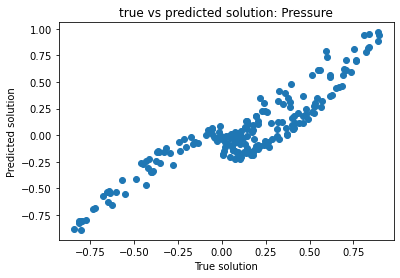

In [771]:
plt.scatter(Y_test_true_pressure,Y_test[0])
plt.title("true vs predicted solution: Pressure")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

In [775]:
Y_test[1].shape

(200, 2)

In [773]:
Y_test_true_vel_x.shape

(200, 1)

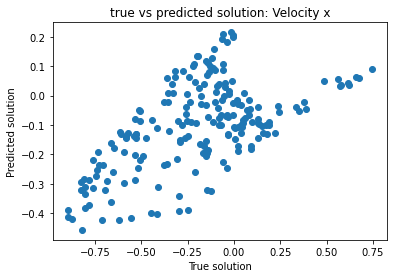

In [781]:
plt.scatter(Y_test_true_vel_x,Y_test[1][:,0])
plt.title("true vs predicted solution: Velocity x")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

## Saving and loading the trained FluidLearn model

### Saving the model

In [25]:
os.makedirs("./saved_models", exist_ok=True)

#Saving the model using .h5 extension
pinn_model.save("./saved_models/trained_model_1")


INFO:tensorflow:Assets written to: ./saved_models_2/trained_model_1/assets


In [38]:
# loaded_model = keras.models.load_model("./save_models/trained_model_1",
#                                       custom_objects={"space_dim": space_dim, 
#                 "time_dep": time_dep, "output_dim": output_dim,
#                  "n_hid_lay": n_hid_lay, "n_hid_nrn": n_hid_nrn,
#                 "act_func": act_func})
    loaded_model = keras.models.load_model("./saved_models/trained_model_1",
                                          custom_objects={"u_loss": Losses.u_loss,
                                                         "pde_loss": Losses.pde_loss})


In [39]:
new_predicted_test=loaded_model.predict(x=X_test_st)

In [40]:
np.concatenate([Y_test,new_predicted_test], axis=1)

array([[ 0.25523862,  0.25523862],
       [ 0.12629034,  0.12629034],
       [-0.34698167, -0.34698167],
       [-0.37192294, -0.37192294],
       [-0.12948751, -0.12948751],
       [ 0.5485113 ,  0.5485113 ],
       [ 0.5945483 ,  0.5945483 ],
       [-0.11641303, -0.11641303],
       [-0.2874321 , -0.2874321 ],
       [-0.8821924 , -0.8821924 ],
       [ 0.722512  ,  0.722512  ],
       [-0.3887959 , -0.3887959 ],
       [ 0.59087133,  0.59087133],
       [ 0.27543485,  0.27543485],
       [ 0.63271695,  0.63271695],
       [-0.09031705, -0.09031705],
       [ 0.5781835 ,  0.5781835 ],
       [ 0.2798178 ,  0.2798178 ],
       [ 0.35892668,  0.35892668],
       [-0.44289055, -0.44289055],
       [-0.62416124, -0.62416124],
       [ 0.12334868,  0.12334868],
       [-0.06602845, -0.06602845],
       [ 0.19845653,  0.19845653],
       [ 0.61451155,  0.61451155],
       [ 0.71627766,  0.71627766],
       [ 0.11241148,  0.11241148],
       [ 0.23309457,  0.23309457],
       [ 0.08702155,

In [41]:
loaded_model.fit(x=X_tr, y=[Y_tr, Y_tr], epochs=1)

125/125 [==============================] - 1s 8ms/step - loss: 0.0035 - output_1_loss: 0.0015 - output_2_loss: 0.0020


![flow_learn_diagram](https://user-images.githubusercontent.com/35903705/90431457-b2ebd800-e08e-11ea-9bdd-dde98b2673f7.jpg)

## Creating class for generating boundary conditions

In [1]:
import numpy as np

In [43]:
class BcIcDataManufact:
    """
    Class to generate Boundary and Initial Condition Data.
    """
    def __init__(self, dom_bounds):
        """
        Attributes:
        dom_bounds (list of lists) - list of  list, where each
        element list is an intervel giving bound for interval from
        which random points needs to be generated.
        dim = dimension of the space where the points are generated
        """
        self.__dom_bounds = dom_bounds
        self.__dim = len(dom_bounds)
        
        
    def generate_uniform_data(self, dom_bounds, n):
        """
        Generates uniformly distributed points in intervals defined by dom_bounds
        
        Arguments:
        dom_bounds (list of lists) - list of  list, where each
        element list is an intervel giving bound for interval from
        which random points needs to be generated.
        n (int) - number of data points to be generated from each interval
        
        Return: np.ndarray of shape (n,len(dom_bounds))
        """
        generated_data = np.zeros((n,len(dom_bounds)))
        
        for i in range(len(dom_bounds)):
            generated_data[:,i] = np.random.uniform(low=dom_bounds[i][0],
                                                   high=dom_bounds[i][1],
                                                   size=n)
        return generated_data
    
    def generate_uniform_bc_ic(self, n):
        """
        Generates uniformly distributed boundary/Initial condition points
        lying on the boundary of hypercube defined by the intervals stored 
        in self.__dom_bounds
        
        Arguments:
        n (int) - number of data points to be generated from each part of
        the boundary.
        
        Return: np.ndarray of shape (k*n,self.__dim), where k 
        is the number of faces(boundaries) of the hypercube which is indeed
        equal to 2*dim.
        """
        #allocating space for the output ndarray
        generated_data = np.zeros((2*self.__dim*n,self.__dim))
        
        #to keep track of where to add elements in generated_data
        entry_index = 0 
        
        for dim_i in range(self.__dim): #going over each element in self.__dom_bound
            for j in range(2): #to iterate over lower and upper bound
                generated_sub_data = self.generate_uniform_data(self.__dom_bounds, n)
    
                #Making the appropriate column corresponding to boudnayr condition,
                #x_i = upper/lower bound
                generated_sub_data[:,dim_i] = self.__dom_bounds[dim_i][j]*np.ones(n)
                
                #finally adding the generated bc/ic to final output array
                generated_data[entry_index:entry_index+n,:] = generated_sub_data
                
                entry_index += n
        
        return generated_data
        

In [46]:
dom_bounds = [[0,4],[-10,10],[100,400]]
# dom_bounds = [[0,4],[-10,10]]
data_gen = BcIcDataManufact(dom_bounds)

In [57]:
data_gen.generate_uniform_bc_ic(4)

array([[ 0.00000000e+00,  9.50347875e+00,  2.50161086e+02],
       [ 0.00000000e+00, -4.48454653e+00,  3.79277041e+02],
       [ 0.00000000e+00, -1.61914177e+00,  2.82628171e+02],
       [ 0.00000000e+00, -7.01665973e+00,  2.33695908e+02],
       [ 4.00000000e+00, -7.56372069e+00,  2.33382063e+02],
       [ 4.00000000e+00,  2.92679889e+00,  3.62948567e+02],
       [ 4.00000000e+00, -2.90052315e+00,  2.84367323e+02],
       [ 4.00000000e+00,  6.86134310e+00,  3.89204475e+02],
       [ 1.98764418e+00, -1.00000000e+01,  3.58389028e+02],
       [ 2.78595440e+00, -1.00000000e+01,  1.45766110e+02],
       [ 1.78722174e+00, -1.00000000e+01,  3.07758107e+02],
       [ 2.78485496e+00, -1.00000000e+01,  2.32871352e+02],
       [ 1.44176878e+00,  1.00000000e+01,  1.48094839e+02],
       [ 3.06009776e+00,  1.00000000e+01,  1.57893701e+02],
       [ 2.49446942e+00,  1.00000000e+01,  2.78440673e+02],
       [ 2.87549317e-01,  1.00000000e+01,  2.66162642e+02],
       [ 1.66341673e+00,  1.42060456e+00

In [30]:
dom_bounds = [[0,4],[-10,10],[100,400]]
data = data_gen.generate_uniform_data(dom_bounds, 5)
data

array([[  2.47752523,  -8.1319419 , 162.22961052],
       [  1.71536612,   1.63607556, 382.68388834],
       [  0.58291772,   2.79663019, 393.06020976],
       [  1.97114857,  -9.71022968, 267.65181066],
       [  2.64308867,   9.51026909, 315.14706271]])

In [ ]:
data = np.concatenate([data])

In [29]:
data[0:2,].shape

IndexError: too many indices for array